<a href="https://colab.research.google.com/github/rubycho/cv-notes/blob/master/CV01/CV01%20Transfer%20Learning%2C%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cats vs Dogs Classifier

We will build a classifier that distinguishes cats and dogs.

Previously in CV00, we have built a simple traffic sign classifier, but its dataset image size (H=100, W=100) is too small to apply it to transfer learning models. (and I tried to do so, but it worked poorly)

So, I changed the topic and the dataset as cats vs dogs, provided on `tfds`.

Plus, it seems easier than CV00, cause now we use binary cross entropy and simgoid, instead of categorical and softmax. Now we care only 0 or 1.

The code is based on [Transfer learning & fine-tuning](https://www.tensorflow.org/guide/keras/transfer_learning#top_of_page) from Tensorflow.

### Prepare Dataset

We will use `tfds` instead of creating image data generator manually.

In [1]:
# **only** install this if you have problem with printing cardinality on the next snippet.
!pip install tfds-nightly

     |████████████████████████████████| 3.5MB 5.5MB/s 


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]"],
    as_supervised=True
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete5C2DL9/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of test samples: 2326


In [3]:
size = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### Build model

Use VGG16 model.

In [4]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

model = VGG16(include_top=False, input_shape=(*size, 3))
model.trainable = False

inputs = Input((*size, 3))
x = preprocess_input(inputs)

x = model(x)

x = Flatten()(x)
x = Dense(4096, activation='relu', kernel_initializer='he_normal')(x)
x = Dense(4096 , activation='relu', kernel_initializer='he_normal')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=x)
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_______________________________________________________

### Compile and Fit

Compile, let the model fit to the training set, and validate with dev set.

Run for 10 epochs.


In [5]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
history = model.fit(
    x=train_ds,
    epochs=10,
    validation_data=test_ds
)

Epoch 1/10
291/291 [==============================] - 29s 98ms/step - loss: 5.5862 - binary_accuracy: 0.9568 - val_loss: 0.1685 - val_binary_accuracy: 0.9725
Epoch 2/10
291/291 [==============================] - 27s 93ms/step - loss: 0.1644 - binary_accuracy: 0.9852 - val_loss: 0.1259 - val_binary_accuracy: 0.9802
Epoch 3/10
291/291 [==============================] - 27s 93ms/step - loss: 0.0171 - binary_accuracy: 0.9962 - val_loss: 0.1694 - val_binary_accuracy: 0.9824
Epoch 4/10
291/291 [==============================] - 27s 93ms/step - loss: 0.0182 - binary_accuracy: 0.9965 - val_loss: 0.2772 - val_binary_accuracy: 0.9768
Epoch 5/10
291/291 [==============================] - 27s 93ms/step - loss: 6.2589e-04 - binary_accuracy: 0.9997 - val_loss: 0.2534 - val_binary_accuracy: 0.9811
Epoch 6/10
291/291 [==============================] - 27s 93ms/step - loss: 0.0818 - binary_accuracy: 0.9942 - val_loss: 0.4896 - val_binary_accuracy: 0.9729
Epoch 7/10
291/291 [============================

### Plot accuracy

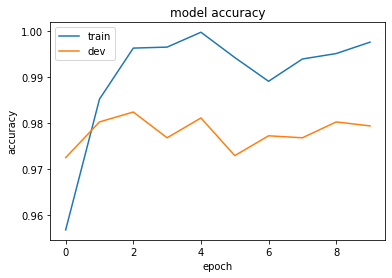

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'])
plt.show()

### See it works OK

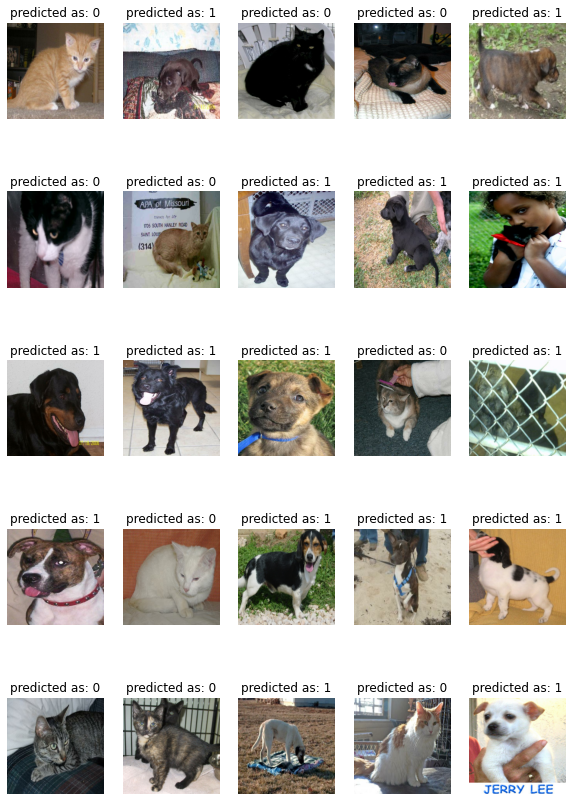

In [8]:
# take 1 batch
ds = test_ds.take(1)
predictions = model.predict(ds)

ds = list(ds)
plt.subplots(5, 5, figsize=(10, 15))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.axis('off')

  # [(data * 32, label * 32)]
  plt.imshow(ds[0][0][i, :, :, :] / 255)
  plt.title('predicted as: %d' % predictions[i])
plt.show()